In [1]:
import pandas as pd
data = pd.read_csv("./data.csv")
data.columns = ["URL", "Text", "Start-Indices", "End-Indices", "Text-Type"]
#data["Text-Type"] = 5
data.head()

,URL,Text,Start-Indices,End-Indices,Text-Type
0,https://stackoverflow.com/questions/37958781,So does that mean it is better than the defaul...,[],[],0
1,https://stackoverflow.com/questions/37958781,It is fundamentally a heuristic based approach...,[],[],0
2,https://stackoverflow.com/questions/37958781,Calling it a heuristic approach is not meant t...,[],[],0
3,https://stackoverflow.com/questions/37958781,"The text in question was Moby Dick, and the od...",[],[],0
4,https://stackoverflow.com/questions/37958783,A table containing only debit and credit colum...,[],[],0


In [2]:
trainDF = pd.DataFrame()
trainDF['text'] = data["Text"]
trainDF['label'] = data["Text-Type"]

In [3]:
import gensim
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()
sentence_corpus=[]
for sentence in trainDF["text"]:
    sentence_corpus.append(tw.tokenize(sentence))

In [6]:
# from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(sentence_corpus)
sequences = tokenizer_obj.texts_to_sequences(sentence_corpus)

In [8]:
max_length = max([len(s.split()) for s in data["Text"]])
print(max_length)
data.shape
from tensorflow.keras.preprocessing.sequence import pad_sequences
word_index =tokenizer_obj.word_index
review_pad = pad_sequences(sequences,maxlen=max_length)
print(review_pad.shape)
print(len(word_index))

3046
(23617, 3046)
42343


In [10]:
model = gensim.models.Word2Vec(sentence_corpus, min_count=1,vector_size=300,workers=4)

In [11]:
model.train(sentence_corpus, total_examples=len(sentence_corpus), epochs=50)

(28279169, 39129750)

In [12]:
filename = 'w2vmodeltweety.txt'
model.wv.save_word2vec_format(filename,binary=False)

In [15]:
import os
import numpy
embeddings_index = {}
f=open(os.path.join('',filename),encoding='utf-8')
vocab = list(model.wv.index_to_key)
for word in vocab:
    #values=line.split()
    #word=values[0]
    coefs=numpy.asarray(model.wv[word])
    embeddings_index[word]=coefs
f.close()

In [16]:
num_words = len(word_index)+1
EMBEDDING_DIM=300
embedding_matrix=numpy.zeros((num_words,EMBEDDING_DIM))
for word,i in word_index.items():
    if i>num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
embedding_matrix.shape

(42344, 300)

In [19]:
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

In [20]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(next(iter(word2vec.values())))
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in tw.tokenize(X)
        ])

In [21]:
import numpy as np
w2v_features = []
for row in data["Text"]:
    r = MeanEmbeddingVectorizer(w2v).transform(row)
    w2v_features.append(np.mean(r,axis=0))

In [22]:
#print((np.mean(r,axis=0)))

In [23]:
len((tw.tokenize(data["Text"][0])))

23

In [27]:
len(w2v_features)

23617

In [31]:
w2vfeat = pd.DataFrame(columns = ["vector", "Text-Type"])

In [33]:
import warnings
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
# Restore default warning behavior if needed
# warnings.simplefilter(action='default', category=FutureWarning)

i=0
for row in data["Text"]:
    w2vfeat = w2vfeat.append(pd.Series([w2v_features[i], data["Text-Type"]],index=w2vfeat.columns), ignore_index=True)
    #w2vfeat["vector"]=[w2v_features[i]]
    #w2vfeat["Text-Type"]=data["Text-Type"], index=dfObj.columns 
    i=i+1

In [34]:
print(w2vfeat.head(1)["vector"])

0    [0.23184676, -0.85348487, -0.42577475, -0.7061...
Name: vector, dtype: object


In [38]:
print(type(model.wv[model.wv.index_to_key]))

<class 'numpy.ndarray'>


In [39]:
q = np.array(w2v_features)

In [40]:
type(q)

numpy.ndarray

In [41]:
import numpy as np
pc0 = []
pc1 = []
pc2 = []
for i,row in data.iterrows():
    r = MeanEmbeddingVectorizer(w2v).transform(row["Text"])
    if(row["Text-Type"]==0):
        pc0.append(np.mean(r,axis=0))
    elif(row["Text-Type"]==1):
        pc1.append(np.mean(r,axis=0))
    else:
        pc2.append(np.mean(r,axis=0))

In [42]:
from sklearn.preprocessing import StandardScaler
st_arr = StandardScaler().fit_transform(q)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(st_arr)
r#esult = pca.fit_transform(q)

array([[ 0.7414486 , -0.4486907 , -0.17803094, ..., -0.5045716 ,
        -0.85335207,  0.5806532 ],
       [-0.75261086,  2.7392027 ,  3.8631473 , ..., -0.48230472,
         0.2550787 ,  0.9765277 ],
       [-0.75261086,  2.7392027 ,  3.8631473 , ..., -0.48230472,
         0.2550787 ,  0.9765277 ],
       [ 0.3901592 , -0.16268858, -0.37360382, ..., -0.17032407,
         0.11461952,  0.59874564],
       [ 0.3207572 ,  0.66521955,  1.2532477 , ..., -0.21596904,
         2.6862059 ,  0.50353485],
       [ 0.43719554,  2.2877922 ,  2.2784157 , ..., -1.091892  ,
         2.1100862 , -0.8748954 ]], dtype=float32)

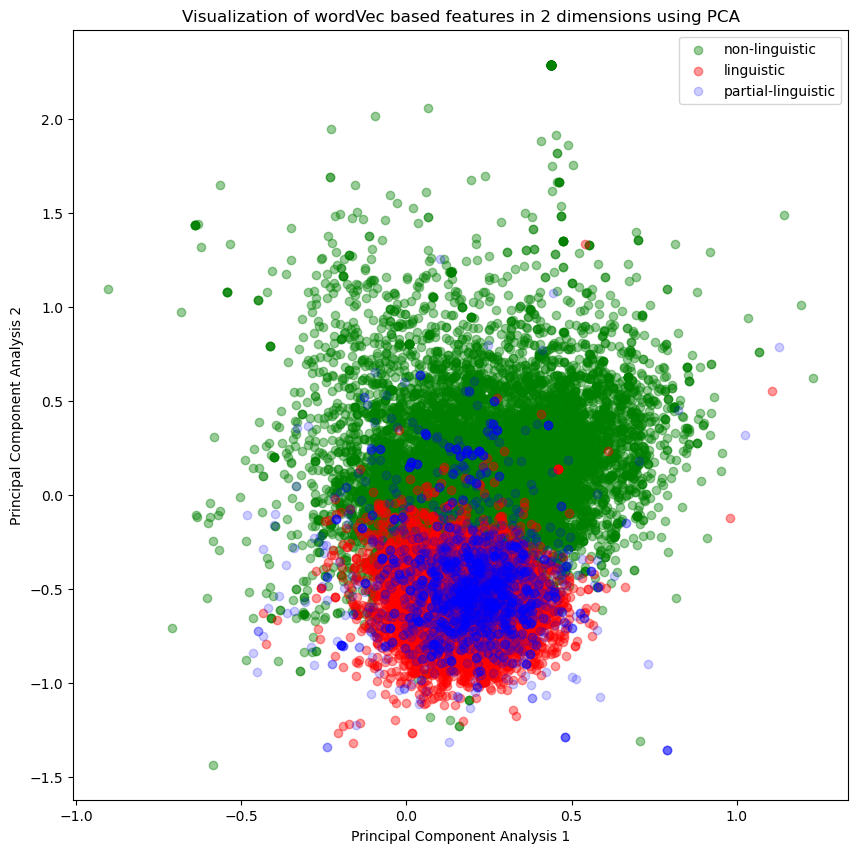

In [44]:
pca_label0 = np.array(pc0)
pca_label1 = np.array(pc1)
pca_label2 = np.array(pc2)
plt.figure(figsize=(10,10))
plt.scatter(pca_label2[:,0], pca_label2[:,1], c = 'g', alpha = 0.4, label='non-linguistic')
plt.scatter(pca_label0[:,0], pca_label0[:,1], c = 'r', alpha = 0.4, label='linguistic')
plt.scatter(pca_label1[:,0], pca_label1[:,1], c = 'b', alpha = 0.2, label='partial-linguistic')
plt.xlabel('Principal Component Analysis 1')
plt.ylabel('Principal Component Analysis 2')
plt.title('Visualization of wordVec based features in 2 dimensions using PCA')
plt.legend()
#plt.gca().legend(('liguistic','partial-liguistic', 'non-linguistic'))
plt.show()

In [47]:
X=model.wv[model.wv.index_to_key]
pcaw = PCA(n_components=2)
result = pca.fit_transform(X)

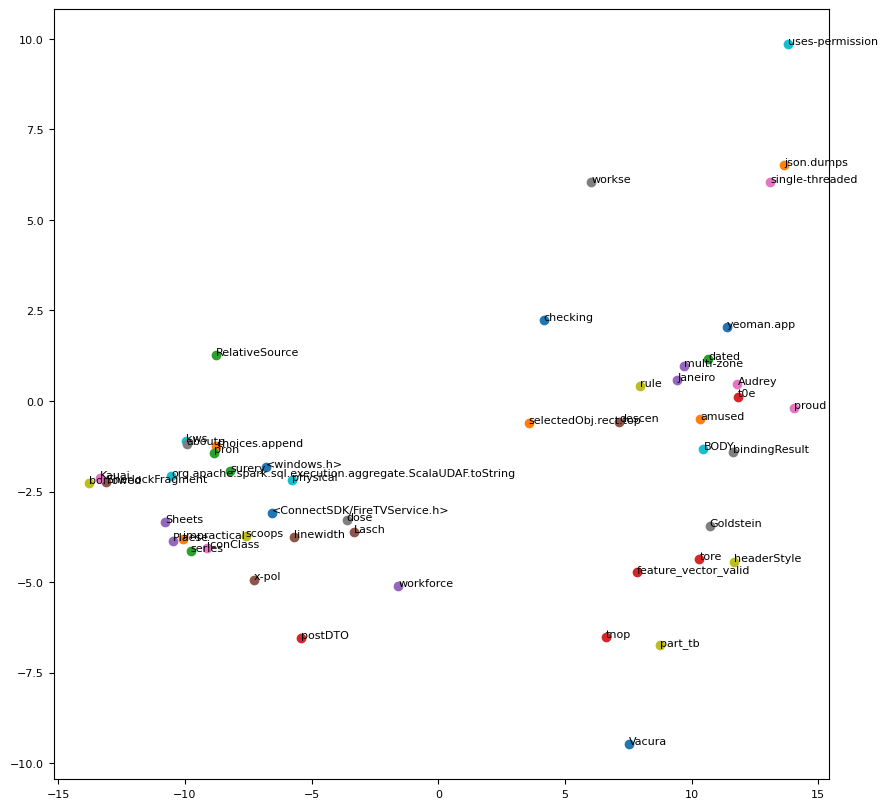

In [52]:
#plt.figure(figsize=(10,10))
import random
from matplotlib import pyplot as plt
# plt.show()
plt.rcParams.update({'font.size': 8})
words = list(model.wv.index_to_key)
#words=['void','public','protected','main','why','how','what','on','the','to','in','of','and']
#words=['finding','Breakthroughs','why','to','query']
#words=words[230:280]
plt.figure(figsize=(10,10))
for i in range(50):
#for word in words:
    word = random.choice(words)
    index = words.index(word)
    #rint(index,word)
    plt.scatter(result[i, 0], result[i, 1])
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    words.remove(word)
plt.show()

In [53]:
model.wv.similar_by_word('public',5)

[('private', 0.5684886574745178),
 ('protected', 0.5169636607170105),
 ('__init', 0.48070988059043884),
 ('WebSecurityConfigurerAdapter', 0.45141395926475525),
 ('onMapReady', 0.4461721181869507)]

In [54]:
model.wv.similar_by_word('know',5)

[('imagine', 0.5905610918998718),
 ('understand', 0.5684097409248352),
 ('explain', 0.5214362144470215),
 ('suggest', 0.4937214255332947),
 ('love', 0.48862069845199585)]